In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import soundfile as sf
import warnings
from joblib import dump, load


warnings.filterwarnings("ignore")

# === Step 1: Define Paths ===
DATA_DIR = Path(r"C:\Users\Sumit\ownCloud\Documents\AppliedSignalProcessing\Voices\AnimalSound")
MODEL_PATH = "animal_sound_model.h5"  # Keras Model will be saved here
ENCODER_PATH = "label_encoder.pkl"

# === Step 2: Extract Features Function ===
def extract_features(file_path, max_length=50):
    try:
        audio, sr = librosa.load(file_path, sr=16000)  # Load audio at 16kHz
        if len(audio) == 0:
            return None
        
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)  # Extract 40 MFCC (Mel Frequency Cepstral Coefficients best for sound classification.) features

        # Pad or truncate to maintain uniform size
        if mfcc.shape[1] < max_length:
            mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :max_length]

        return mfcc
    except Exception as e:
        print(f"Skipping {file_path}: {e}")
        return None

# === Step 3: Load Data ===
file_list = list(DATA_DIR.glob("*.wav"))  # Find all .wav files
labels = [file.stem.split("(")[0] for file in file_list]  # Extract labels from filenames

features = [extract_features(file) for file in tqdm(file_list, desc="Extracting Features")]

# Remove invalid extractions
valid_data = [(f, l) for f, l in zip(features, labels) if f is not None]
if not valid_data:
    raise ValueError("No valid audio files found!")

features, labels = zip(*valid_data)
X = np.array(features)
y = np.array(labels)

# === Step 4: Encode Labels ===
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# === Step 5: Split Data ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Step 6: Scale Features ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

# === Step 7: Define Keras CNN Model ===
model = keras.Sequential([
    layers.Input(shape=(40, 50, 1)),  # Input shape (MFCC features)
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(len(np.unique(y)), activation="softmax")  # Output neurons = Number of classes
])

# Compile Model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train Model
model.fit(X_train, y_train, epochs=70, batch_size=4, validation_data=(X_test, y_test))

# Save Model & Encoder
model.save("animal_sound_model.keras")  # Save model in Keras format
dump(encoder, ENCODER_PATH)

print(f"Model saved as animal_sound_model.keras")
print(f"Label encoder saved as {ENCODER_PATH}")

# === Step 8: Predict on New Audio ===
def predict_audio(file_path):
    features = extract_features(file_path)
    if features is None:
        return None

    features = scaler.transform(features.reshape(1, -1)).reshape(1, 40, 50, 1)  # Reshape for CNN
    prediction = model.predict(features)
    predicted_label = encoder.inverse_transform([np.argmax(prediction)])[0]

    return predicted_label




Extracting Features: 100%|██████████| 442/442 [00:30<00:00, 14.37it/s]


Epoch 1/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1216 - loss: 2.8567 - val_accuracy: 0.1461 - val_loss: 2.6340
Epoch 2/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3369 - loss: 2.1326 - val_accuracy: 0.2809 - val_loss: 2.2812
Epoch 3/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5954 - loss: 1.3478 - val_accuracy: 0.3708 - val_loss: 2.1367
Epoch 4/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7580 - loss: 0.7728 - val_accuracy: 0.5169 - val_loss: 2.2353
Epoch 5/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9227 - loss: 0.3530 - val_accuracy: 0.4719 - val_loss: 2.8914
Epoch 6/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9294 - loss: 0.2472 - val_accuracy: 0.5056 - val_loss: 3.3381
Epoch 7/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9775 - loss: 0.1141 - val_accuracy: 0.5281 - val_loss: 3.5812
Epoch 8/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0262 - val_accuracy: 0.5506 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Rooster 



====================		This is a sound recording of a Rooster  :)		====================


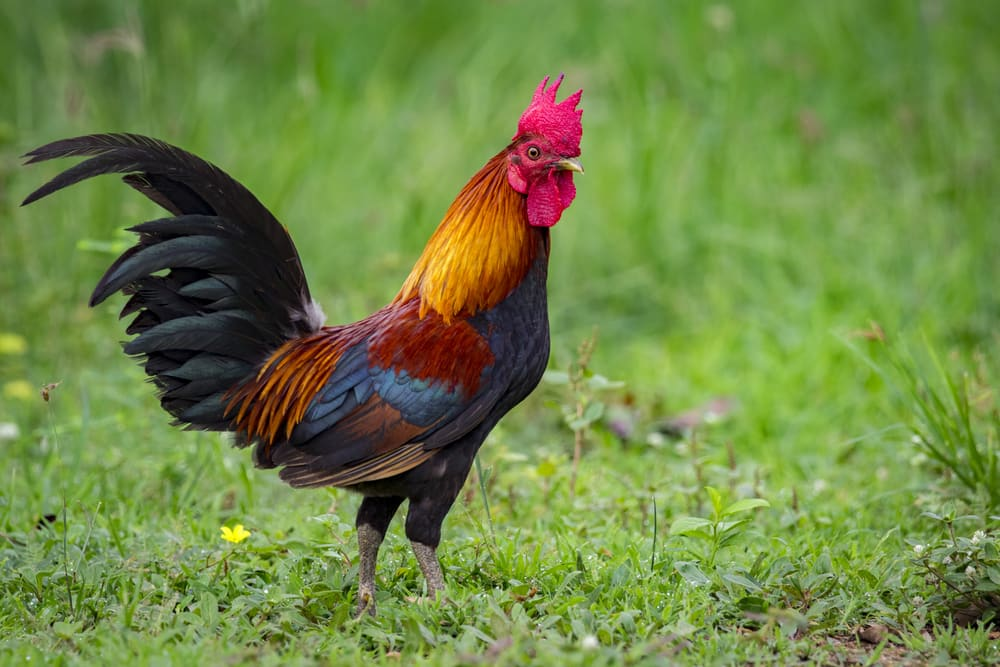

In [2]:
test_file = "C:/Users/Sumit/Downloads/Sample.wav"  # Replace with your test file path
from IPython.display import Image, display
predicted_label = predict_audio(test_file)
print(f"{predicted_label}")
if predicted_label == "Rooster ": 
    print(f"\n\n\n\033[1m====================\t\tThis is a sound recording of a {predicted_label} :)\t\t====================\033[0m")
    display(Image(filename=r"C:\Users\Sumit\ownCloud\Documents\AppliedSignalProcessing\img\rooster.jpg"))
    
elif predicted_label == "Cuckoo ":
    print(f"\n\n\033[1m====================\t\tThis is a sound recording of a {predicted_label} :)\t\t====================\033[0m")
    display(Image(filename=r"C:\Users\Sumit\ownCloud\Documents\AppliedSignalProcessing\img\Cuckoo.jpg"))
elif predicted_label == "Cat ":
    print(f"\n\n\033[1m====================\t\tThis is a sound recording of a {predicted_label} :)\t\t====================\033[0m")
    display(Image(filename=r"C:\Users\Sumit\ownCloud\Documents\AppliedSignalProcessing\img\Cat.jpg"))
elif predicted_label == "Owl ":
    print(f"\n\n\033[1m====================\t\tThis is a sound recording of a {predicted_label} :)\t\t====================\033[0m")
    display(Image(filename=r"C:\Users\Sumit\ownCloud\Documents\AppliedSignalProcessing\img\Owl.jpg"))
elif predicted_label == "Nightingale ":
    print(f"\n\n\033[1m====================\t\tThis is a sound recording of a {predicted_label} :)\t\t====================\033[0m")
    display(Image(filename=r"C:\Users\Sumit\ownCloud\Documents\AppliedSignalProcessing\img\nightingale.jpg"))
elif predicted_label == "Loon ":
    print(f"\n\n\033[1m====================\t\tThis is a sound recording of a {predicted_label} :)\t\t====================\033[0m")
    display(Image(filename=r"C:\Users\Sumit\ownCloud\Documents\AppliedSignalProcessing\img\Loon.jpg"))
else:
    print(f"Could not extract features from {test_file}.")


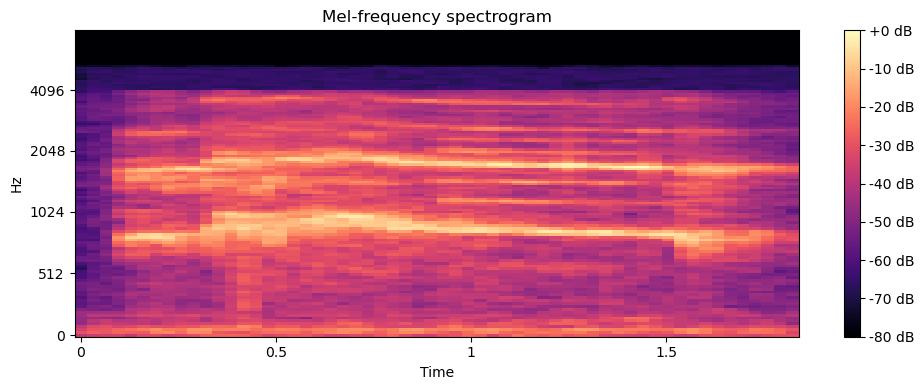

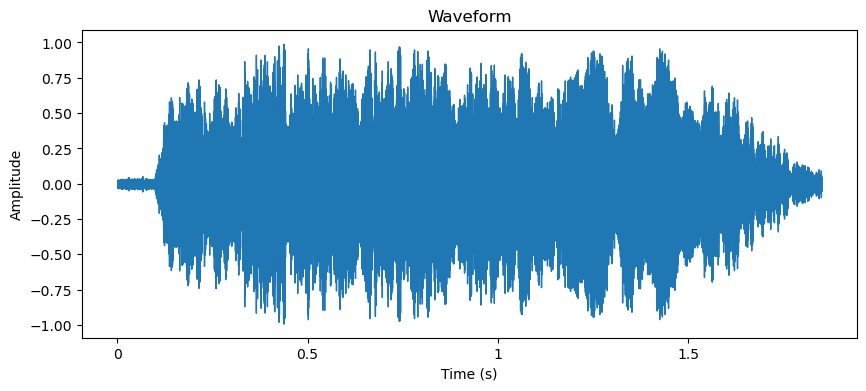

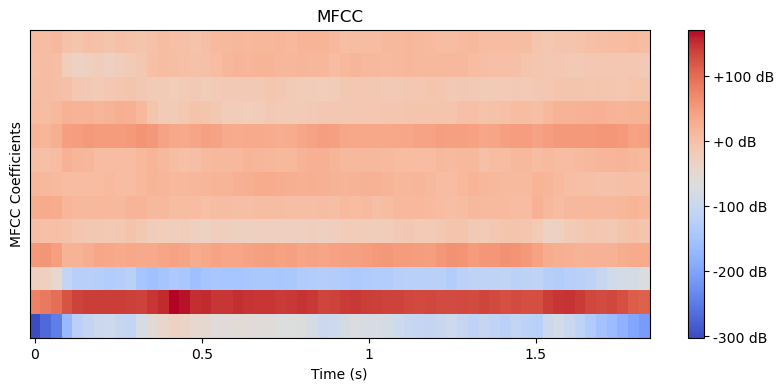

In [3]:

def plot_spectrogram(file_path):
    audio, sr = librosa.load(file_path, sr=16000)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()
import matplotlib.pyplot as plt

plot_spectrogram(test_file) # Call the function to plot the spectrogram of the test file    
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

waveform,sr = librosa.load(test_file, sr=16000)   # Load the audio file
plt.figure(figsize=(10, 4))
librosa.display.waveshow(waveform, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()
import matplotlib.pyplot as plt
import librosa.display
MFCC = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=13)  # Extract MFCC features
plt.figure(figsize=(10, 4))
librosa.display.specshow(MFCC, x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.show()
import numpy as np
import librosa
